In [ ]:
### Data Cleanning

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm


import scipy as sp
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from IPython.display import Image

In [5]:
# This function is to conver the string into int
def Str2float(string):
    try:
        return float(string)
    except:
        return "NaN"

In [251]:
#import 2011
game11_df = pd.read_csv('10-11game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game11_df['Year'] = 2011
game11_df['PTS'] = game11_df['PTS'].map(lambda x: Str2float(x))
game11_df['PTS'] = game11_df['PTS.1'].map(lambda x: Str2float(x))
game11_df = game11_df[game11_df['PTS'].map(lambda x: type(x) is float)]

In [213]:
#import name and their teams 
playerTeam_df = pd.read_csv('salary.csv', header = 1)[['Player','Tm']]
playerTeam_df = playerTeam_df[playerTeam_df['Tm'] != 'Tm']
playerTeam_df = playerTeam_df[playerTeam_df['Player'] != 'Player']
playerTeam_df = playerTeam_df[~pd.isnull(playerTeam_df['Player'])]

In [214]:
#import 2012
game12_df = pd.read_csv('11-12game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game12_df['Year'] = 2012
game12_df['PTS'] = game12_df['PTS'].map(lambda x: Str2float(x))
game12_df['PTS'] = game12_df['PTS.1'].map(lambda x: Str2float(x))
game12_df = game12_df[game12_df['PTS'].map(lambda x: type(x) is float)]

In [215]:
#import 2013
game13_df = pd.read_csv('12-13game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game13_df['Year'] = 2013
game13_df['PTS'] = game13_df['PTS'].map(lambda x: Str2float(x))
game13_df['PTS'] = game13_df['PTS.1'].map(lambda x: Str2float(x))
game13_df = game13_df[game13_df['PTS'].map(lambda x: type(x) is float)]

In [216]:
#import 2014
game14_df = pd.read_csv('13-14game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game14_df['Year'] = 2014
game14_df['PTS'] = game14_df['PTS'].map(lambda x: Str2float(x))
game14_df['PTS'] = game14_df['PTS.1'].map(lambda x: Str2float(x))
game14_df = game14_df[game14_df['PTS'].map(lambda x: type(x) is float)]

In [217]:
#import 2015
game15_df = pd.read_csv('14-15game_stats.csv')[["Visitor/Neutral", "PTS", "Home/Neutral", "PTS.1"]]
game15_df['Year'] = 2015
game15_df['PTS'] = game15_df['PTS'].map(lambda x: Str2float(x))
game15_df['PTS'] = game15_df['PTS.1'].map(lambda x: Str2float(x))
game15_df = game15_df[game15_df['PTS'].map(lambda x: type(x) is float)]

In [219]:
game_all_df=pd.concat([game11_df,game12_df,game13_df,game14_df,game15_df])

In [220]:
Team_names=game_all_df['Visitor/Neutral'].drop_duplicates()
Team_names=list(Team_names)
Team_names[7]

'Atlanta Hawks'

In [231]:
Team_Score = np.zeros(33)
for i in range(33):
    Full_Score=np.append( np.array(Visitor_Score.get_group(Team_names[i])['PTS']), np.array(Home_Score.get_group(Team_names[i])['PTS']) )
    print Team_names[i], np.mean(Full_Score)

Miami Heat 99.0913705584
Houston Rockets 104.850253807
Phoenix Suns 103.225888325
Boston Celtics 97.9567430025
Charlotte Bobcats 97.7435897436
Utah Jazz 100.14213198
Portland Trail Blazers 101.573604061
Atlanta Hawks 98.6852791878
Sacramento Kings 103.822335025
Detroit Pistons 99.6446700508
Milwaukee Bucks 98.269035533
Chicago Bulls 95.4695431472
Indiana Pacers 98.1857506361
New York Knicks 100.47715736
Washington Wizards 99.9568527919
Memphis Grizzlies 96.8045685279
Oklahoma City Thunder 103.814720812
Los Angeles Clippers 102.279187817
Orlando Magic 98.4060913706
Denver Nuggets 106.053299492
Los Angeles Lakers 102.565989848
Cleveland Cavaliers 100.558375635
Philadelphia 76ers 98.6725888325
Minnesota Timberwolves 102.939086294
New Orleans Hornets 95.1
Dallas Mavericks 101.763959391
Golden State Warriors 104.126903553
San Antonio Spurs 102.187817259
Toronto Raptors 100.42893401
New Jersey Nets 97.4594594595
Brooklyn Nets 99.0975609756
New Orleans Pelicans 101.81097561
Charlotte Hornets 

In [815]:
Visitor_Score=game_all_df.groupby(['Visitor/Neutral'])
Home_Score=game_all_df.groupby(['Home/Neutral'])
for i in range(len(Team_names)):
    plt.figure(figsize=(7, 5)) 
    a=np.histogram(np.append( np.array(Visitor_Score.get_group(Team_names[i])['PTS']), np.array(Home_Score.get_group(Team_names[i])['PTS']) ),bins=np.arange(50,150,5),normed=True)
    #plt.plot(np.arange(52.5,147.5,5),a[0],'ro')
    #plt.title(Team_names[i])

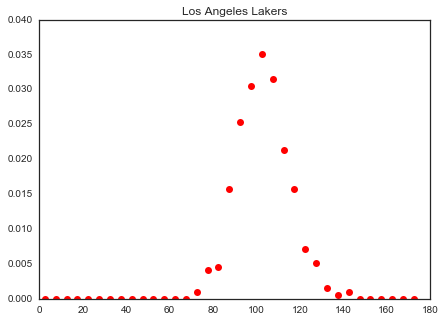

In [252]:
Visitor_Score=game_all_df.groupby(['Visitor/Neutral'])
Home_Score=game_all_df.groupby(['Home/Neutral'])
plt.figure(figsize=(7, 5)) 
team=20
AllScore=np.append( np.array(Visitor_Score.get_group(Team_names[team])['PTS']), np.array(Home_Score.get_group(Team_names[team])['PTS'])) 
a=np.histogram( AllScore ,bins=np.arange(0,180,5),normed=True)
plt.plot(np.arange(2.5,177.5,5),a[0],'ro')
plt.title(Team_names[team])

## b). Derive and compute the maximum likelihood solution for a Gaussian.
First, we take frequentist view. We look for single value of parameter which maximizes likelihood function given the set of data and Poisson distribution.
$$N(X=k;\lambda)=\frac{1}{\sqrt{ 2 \pi \sigma^2} } e^{-\frac{(x-\mu)^2}{2 \sigma^2}} $$

given data sets $D=\{d_0,d_1,...d_N\}$  log-likelihood function is obtained by 
$$\ln L(\lambda : d_1,d_2,...d_N)=\sum_{i=1}^{N} \ln \frac{\lambda^{d_i}e^{-\lambda}}{d_i!} =\sum_{i=1}^{N}(d_i\ln\lambda-\lambda-\ln d_i!) = (\sum_{i=1}^{N}d_i)\ln\lambda-N\lambda-\sum_{i=1}^{N}ln d_i !$$

We maximize $\ln L(\lambda)$ with respect to $\lambda$, given data sets 'hangout_chat_data.csv'.

$$ \frac{\partial \ln L}{\partial \lambda} = 0 = \frac{\sum_{i=1}^{N} d_i}{\lambda} - N$$

$$\lambda = \frac{\sum_{i=1}^{N}d_i}{N}$$

which is equal to mean of the data.

In [206]:
data=pd.DataFrame(map(int, AllScore))

## c). Bayesian solution with Metropolis Hastings
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation.

### Choice of prior: Jeffreys prior of Poisson distribution $p(\lambda)=\frac{1}{\sqrt \lambda}$
Now we want to compare Bayesian solution with Maximum Likelihood solution. For that purpose I use Jeffreys prior to avoid prior strongly influence the posterior distribution.(uninformative prior)




## Metropolice Hastings Algorithm
### Step 1. Start with $\lambda^{0}$
### Step 2. Propose $\lambda^P$ (ex. $N(\lambda^0,c)$)
### Step 3. Check $R = \frac{f(\lambda^{P})P(\lambda^{P} | \lambda^{0})}{f(\lambda^{0})P(\lambda^{0} | \lambda^{P})} $
### Step 4. Accept with probability $min\{1,R\}$
### Step 5. If accept, record $\lambda^{0}=\lambda^{P}$ else $\lambda^{1}=\lambda^{0}$

We want to obtain $p(\lambda|d)=\frac{p(d|\lambda)p(\lambda)}{p(d)}$ since $p(d|\lambda)$ is likelihood function, 
$$p(d|\lambda)=\prod_{i=1}^{N}\frac{\lambda^{d_i}e^{-\lambda}}{d_i !}\propto \lambda ^{N\overline d} e^{-N\lambda}$$




$$p(\lambda|d)\propto p(d|\lambda)p(\lambda) \propto \frac{1}{\sqrt \lambda}  \lambda ^{N\overline d} e^{-N\lambda}  $$

$$ln\, p(\lambda|d)=-\frac{1}{2}ln\lambda +N\overline d\ln\lambda-N\lambda + Constant (1)$$

$$R = ln\ \frac{ p(d|\lambda_1)p(\lambda_1) }{ p(d|\lambda_2)p(\lambda_2) }=ln\ p(d|\lambda_1)p(\lambda_1)-ln\ p(d|\lambda_2)p(\lambda_2) $$



97.7201122576
0.6054


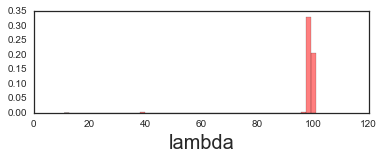

In [207]:
acc_ratio=np.zeros(100)
for z in range(100):


    # given mean of data and lambda and length of data, return log of (likelihood) * (prior) 
    def ln_p(d_mean,lam,len_data):
        return -(1/2)*np.log(lam)+len_data*d_mean*np.log(lam)-len_data*lam



    # length of data
    len_data=len(data)

    # mean of response time
    d_mean = data.mean()[0]

    # total steps of Monte Carlo random walk
    total_steps = 10000

    # store trajectory of random walk for trace plot 
    trace=np.zeros(total_steps)

    # 
    accepted=np.zeros(total_steps)

    # random walk starts from lambda=10 which is a bit off from the maximum likelihood solution
    # but can check convergence well. 
    lam_old= 10
    # store where the random walker was in the beginning
    trace[0]=lam_old

    j=0
    for i in range(total_steps):
        # generate proposal distribution with normal distribution 
        acc = np.random.normal(0,0.7)
        # random walker examines new place
        lam_new=lam_old + acc
        # Calculate log of acceptance ratio
        ln_R = (ln_p(d_mean,lam_new,len_data)-ln_p(d_mean,lam_old,len_data))
        # Decide weather or not to accept the proposal
        if np.log( np.random.rand() ) < ln_R :
            lam_old = lam_new
            accepted[i]+=1

        trace[i]=lam_old
    acc_ratio[z]=accepted.sum()/len(accepted)
print trace.mean()
print accepted.sum()/len(accepted)
plt.subplot(2,1,1)

fig=plt.hist(trace,bins=50,normed = True,color='r',alpha=0.5);
plt.xlabel('lambda',fontsize=20)

mean of lambda is 99.1056035024


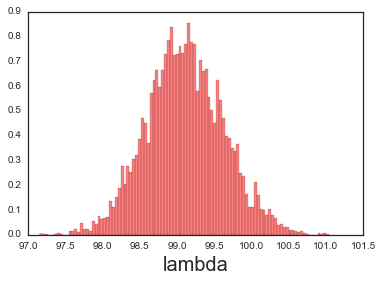

In [208]:
burnin=500
fig=plt.hist(trace[burnin:],bins=100,normed = True,color='r',alpha=0.5);
plt.xlabel('lambda',fontsize=20)
print "mean of lambda is", trace[burnin:].mean()

In [435]:
Age_Score_13=pd.read_csv('./raw-data/13-14Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_13['PTS'] = Age_Score_13['PTS'].map(lambda x: Str2float(x))
Age_Score_13 = Age_Score_13[Age_Score_13['PTS'].map(lambda x: type(x) is float)]

In [ ]:
Age_Score_13=pd.read_csv('./raw-data/13-14Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_13['PTS'] = Age_Score_13['PTS'].map(lambda x: Str2float(x))
Age_Score_13 = Age_Score_13[Age_Score_13['PTS'].map(lambda x: type(x) is float)]

In [595]:
Age_Games_6=pd.read_csv('./raw-data/5-6Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_7=pd.read_csv('./raw-data/6-7Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_8=pd.read_csv('./raw-data/7-8Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_9=pd.read_csv('./raw-data/8-9Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_10=pd.read_csv('./raw-data/9-10Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_11=pd.read_csv('./raw-data/10-11Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_12=pd.read_csv('./raw-data/11-12Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_13=pd.read_csv('./raw-data/12-13Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_14=pd.read_csv('./raw-data/13-14Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_15=pd.read_csv('./raw-data/14-15Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_16=pd.read_csv('./raw-data/15-16Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')

Age_Games_6['G'] = Age_Games_6['G'].map(lambda x: Str2float(x))
Age_Games_6 = Age_Games_6[ Age_Games_6['G'].map(lambda x: type(x) is float)]


Score_all=pd.concat([Age_Games_6,Age_Games_7,Age_Games_8,Age_Games_9,Age_Games_10,Age_Games_11,Age_Games_12,Age_Games_13,Age_Games_14,Age_Games_15,Age_Games_16])
Score_all['G'] = Score_all['G'].map(lambda x: Str2float(x))
Score_all = Score_all[Score_all['G'].map(lambda x: type(x) is float)]

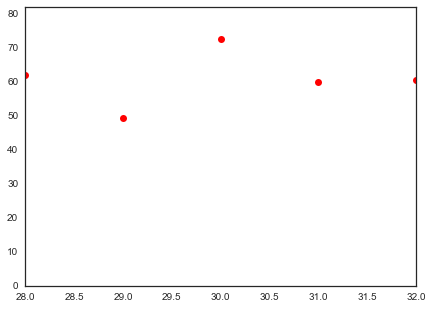

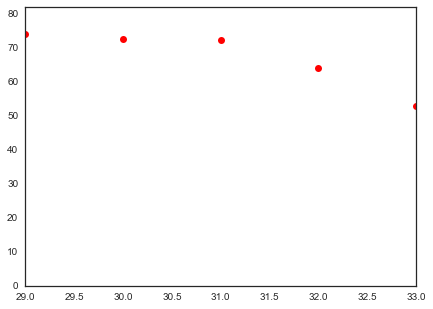

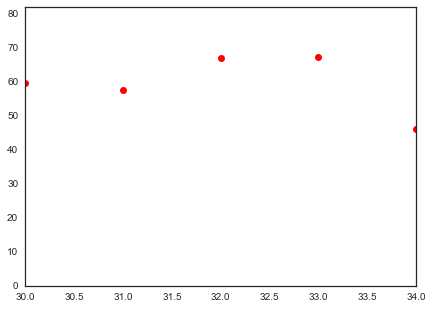

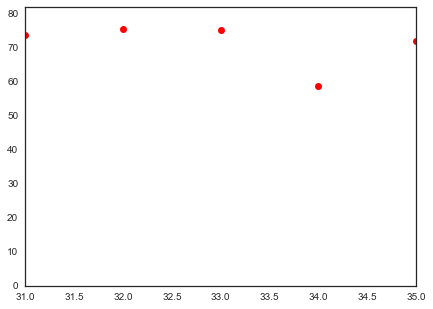

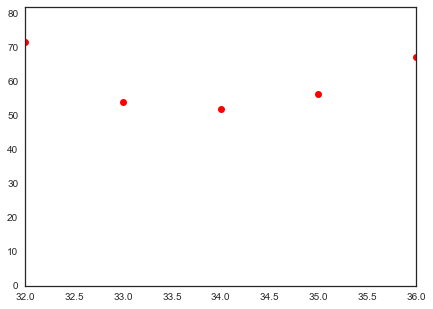

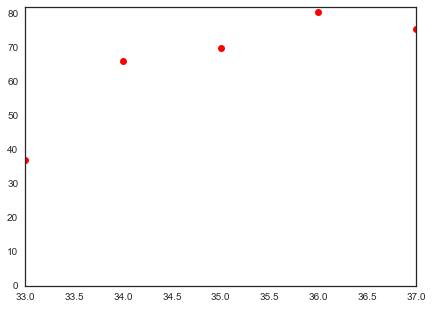

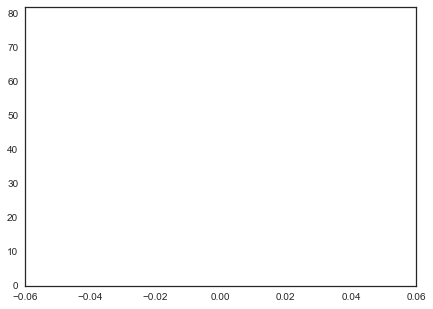

In [602]:
total_years=5
for age in range(28,35):
    Age_Games_6_GbyA=Age_Games_6.groupby(['Age'])
    PlayerList=list( Age_Games_6_GbyA.get_group(str(age))['Player'] )

    SumGame=np.zeros(total_years)
    NumPlayers=0
    plt.figure(figsize=(7, 5)) 
    for i in range(len(PlayerList)): 
        playyears=len(Score_all_GbyP.get_group(PlayerList[i])['G'])
        if playyears>total_years:
            Score_all_GbyP=Score_all.groupby(['Player'])
            SumGame= SumGame + np.array( Score_all_GbyP.get_group(PlayerList[i])['G'] )[:total_years]
            NumPlayers+=1
    plt.plot(np.arange(age,age+total_years),SumGame/NumPlayers,'ro')
    plt.ylim(0,82)

In [632]:
Age_Games_16=pd.read_csv('./raw-data/15-16Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')

In [636]:
Age_Games_16=pd.read_csv('./raw-data/15-16Per100Pos_stats.csv')[["Player", "Age", "G"]].drop_duplicates('Player')
Age_Games_16['G'] = Age_Games_16['G'].map(lambda x: Str2float(x))
Age_Games_16 = Age_Games_16[ Age_Games_16['G'].map(lambda x: type(x) is float)]

Age_Games_16
Age_Games_16_GbyA=Age_Games_16.groupby(['Age'])
PlayerList=list( Age_Games_16_GbyA.get_group('35')['Player'] )
PlayerList

['Matt Barnes',
 'Steve Blake',
 'Matt Bonner',
 'Caron Butler',
 'Nick Collison',
 'Jamal Crawford',
 'Mike Dunleavy',
 'Pau Gasol',
 'Udonis Haslem',
 'Kirk Hinrich',
 'Richard Jefferson',
 'Dahntay Jones',
 'James Jones',
 'Mike Miller',
 'Tayshaun Prince',
 'Luis Scola',
 'David West']

In [680]:
Duncan = pd.read_csv('14-15Tim Duncan.csv')[["PTS"]].replace('Did Not Play','-1')
Duncan['PTS'] = Duncan['PTS'].map(lambda x: Str2float(x))
Duncan = Duncan[ Duncan['PTS'].map(lambda x: type(x) is float)]

Duncan['PTS']
#Duncan['MP'] = Duncan['MP'].map(lambda x: Str2float(x))
#Duncan = Duncan[Duncan['MP'].map(lambda x: type(x) is float)]

0     14
1     16
2     17
3     -1
4     11
5     18
6     12
7     13
8     15
9     10
10    19
11     9
12     7
13    17
14    18
15    14
16    -1
17    14
18    14
19    13
21    23
22    -1
23    19
24    15
25    -1
26    23
27    32
28    -1
29    21
30    15
      ..
54     8
55    30
56     8
57    14
58    20
59    12
60     6
61     5
63    15
64     3
65    12
66    18
67    10
68    17
69    19
70    10
71    12
72     6
73    16
74     8
75    10
76    12
77     6
78     4
79    19
80    12
81     6
82    29
84    22
85    15
Name: PTS, dtype: object

In [560]:
SumGame=np.zeros(10)
NumPlayers=0
for i in range(len(PlayerList)): 
    playyears=len(Score_all_GbyP.get_group(PlayerList[i])['G'])
    if playyears==10:
        Score_all_GbyP=Score_all.groupby(['Player'])
        SumGame= SumGame + np.array( Score_all_GbyP.get_group(PlayerList[i])['G'] )
        NumPlayers+=1

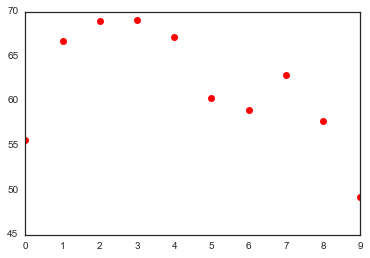

In [561]:
plt.plot(SumGame/NumPlayers,'ro')

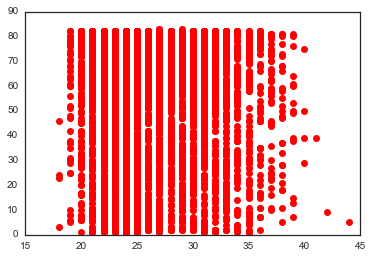

In [590]:
plt.plot(Score_all['Age'], Score_all['G'],'ro')

In [481]:
Games=np.zeros(24)
for i in range(19,43):
    Games[i-19]=Score_all.groupby('Age')['G'].get_group(str(i)).mean()

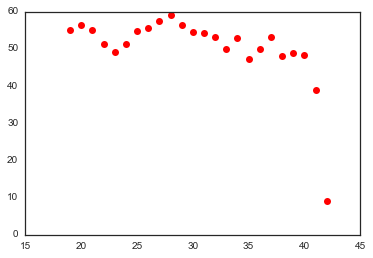

In [484]:
plt.plot(np.arange(19,43),Games,'ro')

In [428]:
Age_Score_12=pd.read_csv('./raw-data/11-12Per100Pos_stats.csv')[["Player", "Age", "PTS\\"]].drop_duplicates('Player')
Age_Score_12['PTS\'] = Age_Score_12['PTS'].map(lambda x: Str2float(x))
Age_Score_12 = Age_Score_12[Age_Score_12['PTS'].map(lambda x: type(x) is float)]

SyntaxError: invalid syntax (<ipython-input-428-f63a11ee4745>, line 2)

In [414]:
Age_Score_13=pd.read_csv('./raw-data/12-13Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_13['PTS'] = Age_Score_13['PTS'].map(lambda x: Str2float(x))
Age_Score_13 = Age_Score_13[Age_Score_13['PTS'].map(lambda x: type(x) is float)]

IOError: File ./raw-data/12-13Per100Pos_stats.csv does not exist

In [413]:
Age_Score_14=pd.read_csv('./raw-data/13-14Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_14['PTS'] = Age_Score_14['PTS'].map(lambda x: Str2float(x))
Age_Score_14 = Age_Score_14[Age_Score_14['PTS'].map(lambda x: type(x) is float)]

In [411]:
Age_Score_15=pd.read_csv('./raw-data/14-15Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_15['PTS'] = Age_Score_15['PTS'].map(lambda x: Str2float(x))
Age_Score_15 = Age_Score_15[Age_Score_15['PTS'].map(lambda x: type(x) is float)]

In [412]:
Age_Score_16=pd.read_csv('./raw-data/15-16Per100Pos_stats.csv')[["Player", "Age", "PTS"]].drop_duplicates('Player')
Age_Score_16['PTS'] = Age_Score_16['PTS'].map(lambda x: Str2float(x))
Age_Score_16 = Age_Score_16[Age_Score_16['PTS'].map(lambda x: type(x) is float)]

In [405]:
Score_all=pd.concat([Age_Score_13, Age_Score_14, Age_Score_15])

# Model player's condition with 1st and 2nd order Markov Model
Once we chose players who should be in a team, we have to chose players who will be on the game today. Our player selection to construct a team has benn based on "Long term achievement" learnt from past years and haven't reflected current player's recent condition. 

Here we first learn each player's scoring pattern from past data using first order Markov Model. Some players score well in theree games in a row and will be in bad condition for three games after. Other players may score well every other game.

This is the simplest way of estimating how much does the player score in next game, based on a result of last game.




# 1st order Markov Model
To begin with, let's start with 1st order Markov Model, in which we estimate the result of this game only based on the last game.

### Pros
The good thing about this first order Markov Model is that, we can create reasonable transition matrix with small data sets. Each NBA player plays in 82 games at most and for example if we use 2 years of data which is around 160, and classify player's conditoin with 5 levels, total elements of transitoin matrix becomes 25. Given 160 data, 25 matrix is already at the border to have reliability. If we want to go higher order, we have to construct bigger matrix and in which case we don't have enough data.

In [66]:
# First import a player's "Points per game" data from past years to learn player's scoreing pattern
PlayerState12 = pd.read_csv('./raw-data/11-12Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState13 = pd.read_csv('./raw-data/12-13Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState14 = pd.read_csv('./raw-data/13-14Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState15 = pd.read_csv('./raw-data/14-15Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState   = pd.concat([PlayerState12, PlayerState13 ,PlayerState14 ,PlayerState15 ])
PlayerState['PTS'] = PlayerState['PTS'].map(lambda x: Str2float(x))
PlayerState   = PlayerState[ PlayerState['PTS'].map(lambda x: type(x) is float)]

# Then calculate average score by the player per game
Mean     = np.mean( PlayerState['PTS'] )

# To classify how well player do or did in a game, we calculate variance
PlusVar     = np.mean( PlayerState['PTS'] )+np.sqrt(np.var( PlayerState['PTS'] ))/2
MinusVar    = np.mean( PlayerState['PTS'] )-np.sqrt(np.var( PlayerState['PTS'] ))/2
PlayerState = np.array(PlayerState['PTS']).astype(float)

for i in range( len(PlayerState) ):
    # if a player score more than "average + Var/2", the player is in the best condition
    if PlusVar    <= PlayerState[i]:
        PlayerState[i] = 4
    
    # if a player score more than "average" but less than "average + Var/2", the player is in the good condition
    elif Mean     <= PlayerState[i] < PlusVar:
        PlayerState[i] = 3
    
    # if a player score less than "average" but more than "average - Var/2", the player is in the worse condition
    elif MinusVar <= PlayerState[i] < Mean: 
        PlayerState[i] = 2

    # if a player score less than "average - Var/2", 
    elif 0 < PlayerState[i] < MinusVar:
        PlayerState[i] = 1
    elif PlayerState[i]     == 0:
        PlayerState[i] = 0
    
Tmatrix=np.zeros([5,5])
for i in range(len(PlayerState)-1):
    Tmatrix[ PlayerState[i] ][ PlayerState[i+1] ] +=1
# normalize
for i in range(5):
    Tmatrix[i]=Tmatrix[i]#/Tmatrix[i].sum()
print( Tmatrix )

[[  0.   2.   2.   2.   5.]
 [  1.  22.  15.  12.  23.]
 [  1.  16.  12.  12.  15.]
 [  3.  20.  14.  21.  11.]
 [  6.  12.  13.  23.  25.]]


/Users/hidenori/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
PlayerState

array([1, 1, 1, 2, 3, 3, 1, 1, 1, 4, 3, 1, 4, 1, 3, 1, 4, 1, 1, 2, 2, 4, 4,
       2, 4, 3, 2, 3, 1, 1, 4, 3, 3, 2, 2, 3, 3, 2, 4, 3, 3, 4, 3, 2, 4, 3,
       4, 1, 1, 4, 2, 2, 4, 4, 2, 4, 4, 3, 4, 4, 4, 2, 1, 4, 4, 3, 2, 2, 4,
       4, 4, 4, 2, 3, 0, 4, 3, 2, 1, 1, 4, 3, 1, 2, 4, 3, 3, 3, 4, 3, 3, 4,
       1, 3, 2, 1, 2, 2, 4, 4, 0, 4, 1, 2, 1, 1, 4, 1, 4, 2, 3, 3, 3, 2, 4,
       4, 4, 4, 3, 4, 4, 3, 1, 4, 4, 3, 3, 4, 0, 3, 1, 4, 3, 3, 1, 1, 0, 1,
       2, 2, 1, 1, 1, 1, 4, 4, 4, 1, 2, 4, 2, 4, 3, 3, 3, 1, 1, 4, 3, 3, 1,
       4, 4, 3, 3, 3, 3, 2, 1, 2, 3, 4, 2, 3, 4, 4, 4, 0, 3, 1, 4, 4, 0, 2,
       2, 3, 3, 1, 4, 1, 1, 1, 1, 3, 2, 1, 4, 4, 4, 2, 1, 3, 3, 2, 1, 4, 2,
       2, 3, 3, 0, 1, 3, 2, 2, 3, 1, 4, 1, 1, 3, 3, 2, 0, 2, 2, 2, 4, 0, 4,
       3, 0, 4, 4, 0, 4, 3, 4, 3, 1, 3, 1, 3, 2, 2, 1, 2, 1, 1, 3, 1, 2, 4,
       2, 1, 4, 1, 2, 3, 1, 4, 1, 2, 4, 2, 1, 1, 3, 1, 2, 3, 1, 3, 4, 1, 2,
       1, 3, 1, 1, 2, 1, 1, 4, 2, 1, 4, 4, 3], dtype=object)

In [948]:
Correct = 0
Wrong   = 0

for i in range(0,len(PlayerState16)-1):
    if np.argmax( Tmatrix[ int( PlayerState16[i] ) ] ) == PlayerState16[i+1]:
        Correct +=1
    else:
        Wrong += 1
print float( Correct )/(Correct+Wrong)

0.131147540984


# Let's interpret the transition matrix of the great basket ball player Tim Duncan.

### If Tim didn't play in last game
Tim is supposed to play well because the most likely condition is "better" or "best"

In [807]:
Tmatrix[0]

array([ 0.   ,  0.125,  0.125,  0.375,  0.375])

### If Tim played poorly in the last game
using Tim in next game is like a gamble, since his condition most likely will be "worst" or "best".

# 2nd order Markov Model
To find longer term correlatoin, we use 2nd order Markov Model which has $25 \times 25$ transition matrix. 

In [65]:
# First import a player's "Points per game" data from past years to learn player's scoreing pattern
PlayerState12 = pd.read_csv('./raw-data/11-12Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState13 = pd.read_csv('./raw-data/12-13Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState14 = pd.read_csv('./raw-data/13-14Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState15 = pd.read_csv('./raw-data/14-15Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState   = pd.concat([PlayerState12, PlayerState13 ,PlayerState14 ,PlayerState15])
PlayerState['PTS'] = PlayerState['PTS'].map(lambda x: Str2float(x))
PlayerState   = PlayerState[ PlayerState['PTS'].map(lambda x: type(x) is float)]

# Then calculate average score by the player per game
Mean     = np.mean( PlayerState['PTS'] )

# To classify how well player do or did in a game, we calculate variance
PlusVar     = np.mean( PlayerState['PTS'] )+np.sqrt(np.var( PlayerState['PTS'] ))/2
MinusVar    = np.mean( PlayerState['PTS'] )-np.sqrt(np.var( PlayerState['PTS'] ))/2
PlayerState = np.array(PlayerState['PTS']).astype(float)

for i in range( len(PlayerState) ):
    # if a player score more than "average + Var/2", the player is in the best condition
    if PlusVar    <= PlayerState[i]:
        PlayerState[i] = 4
    
    # if a player score more than "average" but less than "average + Var/2", the player is in the good condition
    elif Mean     <= PlayerState[i] < PlusVar:
        PlayerState[i] = 3
    
    # if a player score less than "average" but more than "average - Var/2", the player is in the worse condition
    elif MinusVar <= PlayerState[i] < Mean: 
        PlayerState[i] = 2

    # if a player score less than "average - Var/2", 
    elif 0 < PlayerState[i] < MinusVar:
        PlayerState[i] = 1
    elif PlayerState[i]     == 0:
        PlayerState[i] = 0
    
Tmatrix2=np.zeros([25,25])
for i in range(len(PlayerState)-1):
    Tmatrix2[ 5*PlayerState[i-1] + PlayerState[i] ][ 5*PlayerState[i] + PlayerState[i+1] ] +=1
# normalize
for i in range(25):
    if Tmatrix2[i].sum() != 0:
        Tmatrix2[i]=Tmatrix2[i]#/Tmatrix[i].sum()
print Tmatrix2

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  1.  0.  3.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  6.  3.  4.  8.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  3.  4.  4.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  4.
   2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

/Users/hidenori/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [945]:
# First import a player's "Points per game" data from past years to learn player's scoreing pattern
PlayerState16 = pd.read_csv('./raw-data/15-16Tim Duncan.csv')[["PTS"]].replace('Did Not Play','0')
PlayerState16['PTS'] = PlayerState16['PTS'].map(lambda x: Str2float(x))
PlayerState16   = PlayerState16[ PlayerState16['PTS'].map(lambda x: type(x) is float)]

PlayerState16 = np.array( PlayerState16 )

for i in range( len(PlayerState16) ):
    # if a player score more than "average + Var/2", the player is in the best condition
    if PlusVar    <= PlayerState16[i]:
        PlayerState16[i] = 4
    
    # if a player score more than "average" but less than "average + Var/2", the player is in the good condition
    elif Mean     <= PlayerState16[i] < PlusVar:
        PlayerState16[i] = 3
    
    # if a player score less than "average" but more than "average - Var/2", the player is in the worse condition
    elif MinusVar <= PlayerState16[i] < Mean: 
        PlayerState16[i] = 2

    # if a player score less than "average - Var/2", 
    elif 0 < PlayerState16[i] < MinusVar:
        PlayerState16[i] = 1
    elif PlayerState16[i]     == 0:
        PlayerState16[i] = 0

In [949]:
Correct = 0
Wrong   = 0

for i in range(1,len(PlayerState16)-1):
    if np.mod( np.argmax( Tmatrix2[ int( PlayerState16[i-1]*5+PlayerState16[i] ) ] ), 5) == PlayerState16[i+1]:
        Correct +=1
    else:
        Wrong += 1
print "The probability of giving a right answer is " ,float( Correct )/(Correct+Wrong)

The probability of giving a right answer is  0.3


In [87]:
PlayerState
PlayerState_Average=np.zeros( len(PlayerState) -3 )
for i in range(2,len(PlayerState)-3):
    PlayerState_Average[i]=( PlayerState[i-2] + PlayerState[i-1] + PlayerState[i] + PlayerState[i+1] + PlayerState[i+2] )/float(5)

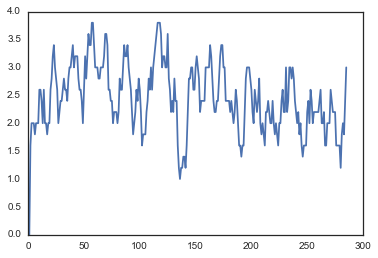

In [88]:
plt.plot( PlayerState_Average )

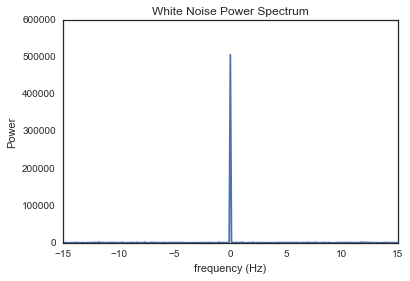

In [8]:
def powspec(samps):
    ps = np.abs(np.fft.fft(samps))**2
    time_step = 1. / 30. #assume Hertz
    freqs = np.fft.fftfreq(samps.size, time_step)
    idx = np.argsort(freqs)
    return freqs[idx], ps[idx]

def plot_powspec(samps, title):
    f,p = powspec(samps)
    plt.plot(f,p)
    plt.xlabel("frequency (Hz)")
    plt.ylabel("Power")
    plt.title(title+ " Power Spectrum")
    
plot_powspec(PlayerState, "White Noise")

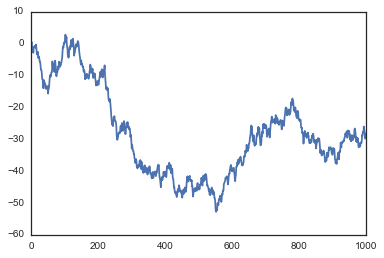

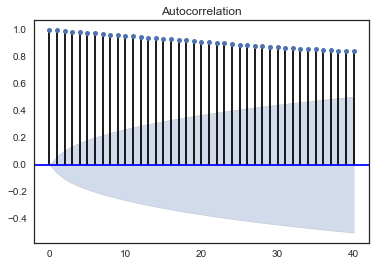

In [54]:
N=1000
z=np.random.randn(N)
x=np.zeros(N)
#we start with x_0=0
for i in np.arange(1,N,1):
    x[i] = x[i-1]+z[i]
plt.plot(x)
tsaplots.plot_acf(x, lags=40);

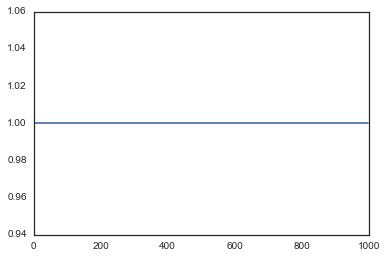

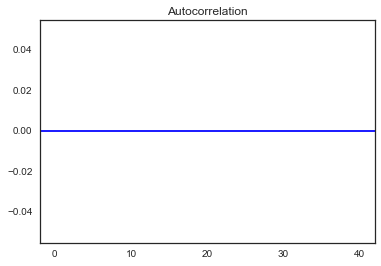

In [61]:
x=np.zeros(1000)+1
plt.plot(x)
tsaplots.plot_acf(x, lags=40);

In [89]:
PlayerState=PlayerState_Average

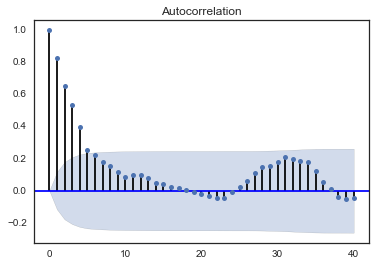

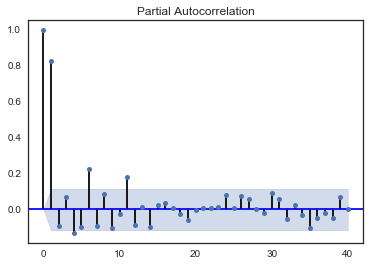

In [90]:
tsaplots.plot_acf( PlayerState  , lags=40);
tsaplots.plot_pacf( PlayerState , lags=40);

In [91]:
PlayerState_train= PlayerState[:200]
PlayerState_test=  PlayerState[200:]

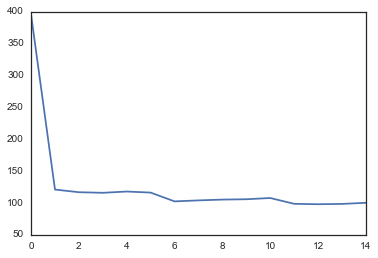

In [92]:
aics=np.zeros(15)
orders=range(15)
fits=[]
for j in orders:
    fit=sm.tsa.ARMA(PlayerState_train, (j,0)).fit(method="mle")
    fits.append(fit)
    aics[j]=fit.aic
plt.plot(orders, aics);

In [93]:
aics

array([ 395.11251002,  120.94438504,  116.76575992,  115.86624468,
        117.86184284,  116.16750262,  102.41388528,  103.9655847 ,
        105.21450295,  105.75085315,  107.68646359,   98.59714749,
         97.94442042,   98.42217332,  100.18166914])

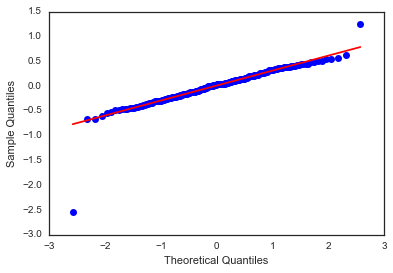

In [94]:
from statsmodels.graphics.api import qqplot
qqplot(fits[10].resid,line='q');

In [95]:
fits[10].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                    ARMA(10, 0)   Log Likelihood                 -41.843
Method:                           mle   S.D. of innovations              0.296
Date:                Mon, 02 May 2016   AIC                            107.686
Time:                        19:21:26   BIC                            147.266
Sample:                             0   HQIC                           123.704
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.5387      0.133     19.150      0.000         2.279     2.799
ar.L1.y        1.0710      0.070     15.212      0.000         0.933     1.209
ar.L2.y       -0.1096      0.109     -1.007      0.315        -0.323     0.104
ar.L3.y       -0.0835      0.111     -0.752      0.453        -0.301     0.134
ar.L4.y        0.1216      0.112      1.090      0.277        -0.097     0.340
ar.L5.y       -0.4373      0.109     -4.025      0.000        -0.650    -0.224
ar.L6.y        0.3377      0.107      3.158      0.002         0.128     0.547
ar.L7.y        0.0076      0.111      0.068      0.945        -0.211     0.226
ar.L8.y        0.0272      0.111      0.244      0.807        -0.191     0.246
ar.L9.y       -0.0744      0.111     -0.668      0.505        -0.293     0.144
ar.L10.y      -0.0199      0.078     -0.254      0.800        -0.173     0.134
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1364           -0.2052j            1.1548           -0.0284
AR.2             1.1364           +0.2052j            1.1548            0.0284
AR.3             0.8958           -0.7726j            1.1829           -0.1133
AR.4             0.8958           +0.7726j            1.1829            0.1133
AR.5            -0.2071           -1.2343j            1.2516           -0.2765
AR.6            -0.2071           +1.2343j            1.2516            0.2765
AR.7            -1.1635           -0.0000j            1.1635           -0.5000
AR.8            -0.9560           -1.5848j            1.8508           -0.3364
AR.9            -0.9560           +1.5848j            1.8508            0.3364
AR.10           -4.3208           -0.0000j            4.3208           -0.5000
------------------------------------------------------------------------------
"""

In [96]:
index_rem=np.arange(200,289,1)
predicts=fits[10].predict(start=200, end=288)
in_predicts = fits[10].predict()

In [97]:
predicts.shape, index_rem.shape, in_predicts.shape

((89,), (89,), (200,))

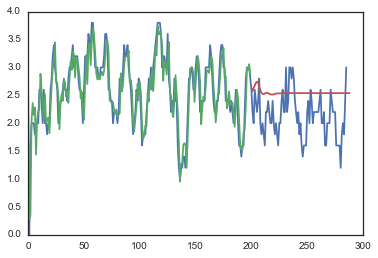

In [98]:
plt.plot(PlayerState)
plt.plot(in_predicts)
plt.plot(index_rem, predicts)